In [1]:
# %% model and sae loading
import os
os.chdir("../")
from sae.sae_model import SparseAutoencoder
import torch 
import pandas as pd 
from tqdm.auto import tqdm
from skvideo.io import vwrite
from IPython.display import Video
from diffusion_policy.policy.diffusion_transformer_lowdim_policy import DiffusionTransformerLowdimPolicy
from diffusion_policy.model.diffusion.transformer_for_diffusion import TransformerForDiffusion
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import collections
import random
from diffusion_policy.env.pusht.pusht_keypoints_env import PushTKeypointsEnv
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed1_acts = pd.read_csv("data/activations_summary.csv")
seed2_acts = pd.read_csv("data/activations_summary_2.csv")

sae_path = "sae/results_layer4_dim2048_k64_auxk64_dead200/checkpoints/last.ckpt"
sae_weights = torch.load(sae_path)
ckpt = {}
for k in sae_weights['state_dict'].keys():
    if k.startswith('sae_model.'):
        ckpt[k.split(".")[1]] = sae_weights['state_dict'][k]
sae = SparseAutoencoder(256, 2048, 64, 64, 32, 200)
sae.load_state_dict(ckpt)
sae.to(device)

ckpt_path = "/work/pi_hzhang2_umass_edu/jnainani_umass_edu/Interp4Robotics/diffusionInterp/data/experiments/low_dim/pusht/diffusion_policy_transformer/train_2/checkpoints/latest.ckpt"
state_dict = torch.load(ckpt_path, map_location=device)
config = state_dict['cfg']
model_config = config['policy']['model']
model_config = {k: v for k, v in model_config.items() if not k.startswith('_target_')}
model = TransformerForDiffusion(**model_config)
noise_scheduler_config = config['policy']['noise_scheduler']
noise_scheduler = DDPMScheduler(**noise_scheduler_config)
policy_params = {
    'model': model,
    'noise_scheduler': noise_scheduler,
    'horizon': config['policy']['horizon'],
    'obs_dim': config['policy']['obs_dim'],
    'action_dim': config['policy']['action_dim'],
    'n_action_steps': config['policy']['n_action_steps'],
    'n_obs_steps': config['policy']['n_obs_steps'],
    'num_inference_steps': config['policy'].get('num_inference_steps', None),
    'obs_as_cond': config['policy'].get('obs_as_cond', False),
    'pred_action_steps_only': config['policy'].get('pred_action_steps_only', False),
}
policy = DiffusionTransformerLowdimPolicy(**policy_params)
policy.load_state_dict(state_dict['state_dicts']['model'])
policy.to(device)


/tmp/ipykernel_1933799/1865078928.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(sae_path)
/tmp/ipykernel_1933799/1865078928.py:38: FutureWarn

DiffusionTransformerLowdimPolicy(
  (model): TransformerForDiffusion(
    (input_emb): Linear(in_features=2, out_features=256, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
    (time_emb): SinusoidalPosEmb()
    (cond_obs_emb): Linear(in_features=20, out_features=256, bias=True)
    (encoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): Mish()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=

In [2]:
# %% helper functions


def theta_tc(obs):
    """
    Calculates the angle between the target block and the current block
    """
    points_to_average = [
    obs[8], obs[1] #, obs[2]
    ]

    # Convert to a NumPy array for easy computation
    points_array = np.array(points_to_average)

    # Compute the average
    mid_pt = np.mean(points_array, axis=0)
    # mid_pt = obs[3]
    low_t = obs[4]
    curr_block_theta = np.arctan2(-(mid_pt[1] - low_t[1]), mid_pt[0] - low_t[0])
    theta_tc = curr_block_theta - np.pi / 4
    return theta_tc, theta_tc * 180 / np.pi, curr_block_theta, curr_block_theta * 180 / np.pi

def dist_tc(obs):
    """
    Calculates the distance between the target block and the current block
    """
    mid_pt_current = obs[3]
    mid_pt_target = [48, 48]
    dist = np.sqrt((mid_pt_current[0] - mid_pt_target[0])**2 + (mid_pt_current[1] - mid_pt_target[1])**2)
    return dist

def Ka(obs):
    """
    Calculates the closest keypoint to agent """
    agent = obs[-1]
    min_dist = np.inf
    min_idx = -1
    for idx, (x, y) in enumerate(obs):
        if idx == 9:
            continue
        else:
            dist = np.sqrt((x - agent[0])**2 + (y - agent[1])**2)
            if dist < min_dist:
                min_dist = dist
                min_idx = idx
    return min_idx

def theta_action(action):
    """
    Calculates the change in angle of the first and last action
    """
    first_angle = np.arctan2(- action[0][1] + action[1][1], action[0][0] - action[1][0])
    last_angle = np.arctan2(- action[-2][1] + action[-1][1], action[-2][0] - action[-1][0])
    change = last_angle - first_angle
    return first_angle, last_angle, change, change * 180 / np.pi

def dist_action(action):
    """
    Calculates the distance between the first and last action
    """
    dist = np.sqrt((action[0][0] - action[-1][0])**2 + (action[0][1] - action[-1][1])**2)
    return dist

def dist_action_mid(action, obs):
    """
    Calculates the average distance between actions and midpoint of target block
    """
    mid_pt_target = obs[3]
    dist = 0
    for idx, (x, y) in enumerate(action):
        dist += np.sqrt((x - mid_pt_target[0])**2 + (y - mid_pt_target[1])**2)
    return dist / len(action)

def dist_action_target(action):
    """
    Calculates the average distance between actions and midpoint of target block
    """
    dist = 0
    for idx, (x, y) in enumerate(action):
        dist += np.sqrt((x - 48)**2 + (y - 48)**2)
    return dist / len(action)

In [3]:
better_acts = pd.read_csv("data/better_activations_summary.csv")
feature_idx = 922 
better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
).head()

,seed,step_idx,timestep,feature_36,feature_37,feature_43,feature_48,feature_60,feature_74,feature_81,...,feature_123,feature_998,feature_353,feature_813,feature_1536,feature_708,feature_2005,feature_1007,feature_815,feature_1687
17096,27242,112,3.0,0.307702,NaN,NaN,NaN,0.074287,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22898,30449,160,1.0,0.083910,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22899,30449,160,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17093,27242,112,6.0,0.125755,NaN,NaN,0.120889,0.173829,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22894,30449,160,5.0,0.117652,0.08486,NaN,0.077789,0.081088,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
2048*50

102400

In [7]:
len(better_acts)

95300

In [4]:
f922_30 = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
)[['seed','step_idx','timestep', f'feature_{feature_idx}']].head(30)

In [5]:
seed, step, timestep, _ = f922_30[['seed', 'step_idx', 'timestep', f'feature_{feature_idx}']].values[0]
# %%
inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
# %%
obs = torch.Tensor(inf_inputs[int(step)][0]['cond_input'])
obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
# %%
points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
print(points1)
# %%
print(theta_tc(points1))
# %%
print(dist_tc(points1))

/tmp/ipykernel_1933799/1431442656.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


[[37.210842 62.80127 ]
 [39.729767 41.35932 ]
 [56.114487 57.294136]
 [44.37665  52.896835]
 [29.787546 64.14371 ]
 [48.689106 59.0212  ]
 [38.1087   48.662895]
 [37.26817  55.73711 ]
 [51.139698 52.359108]
 [52.965385 63.97052 ]]
(0.04967745343909957, 2.846308419018062, 0.8350756, 47.846308419018065)
6.091604768953897


In [13]:
timestep

3.0

In [15]:
inf_inputs[int(step)][int(timestep)].keys()

dict_keys(['timestep', 'trajectory_input', 'cond_input', 'trajectory_output'])

In [16]:
inp_action = torch.Tensor(inf_inputs[int(step)][int(timestep)]['trajectory_input'])
out_action = torch.Tensor(inf_inputs[int(step)][int(timestep)]['trajectory_output'])
print(inp_action.shape, out_action.shape)

torch.Size([1, 10, 2]) torch.Size([1, 10, 2])


In [17]:
for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
    print(f"Seed: {seed}, Step: {step}, Timestep: {timestep}")
    # print(theta_tc(points1))
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    # print(dist_tc(points1))
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    # print(Ka(points2))
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)
    print(f"Theta_tc: {theta_tc_deg}, d_tc: {d_tc}, ClosestK: {ClosestK} \n Delta_theta_act_in: {Delta_theta_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n Delta_dist_act_in: {Delta_dist_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n d_act_curr_in: {d_act_curr_in} d_act_curr_out: {d_act_curr_out} \n d_act_target_in: {d_act_target_in} d_act_target_out: {d_act_target_out}")
    print("\n")

/tmp/ipykernel_1886101/3652908117.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


Seed: 27242.0, Step: 112.0, Timestep: 3.0
Theta_tc: -5.924453607411201, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: 228.07397729338925 Delta_dist_act_out: 8.524491558907302 
 Delta_dist_act_in: 4.612924313909092 Delta_dist_act_out: 8.524491558907302 
 d_act_curr_in: 12.104566669028511 d_act_curr_out: 12.180254695448014 
 d_act_target_in: 15.469839999955132 d_act_target_out: 15.67071618704117


Seed: 30449.0, Step: 160.0, Timestep: 1.0
Theta_tc: -13.120717011274541, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: 2.857662356274125 Delta_dist_act_out: 7.796555249261298 
 Delta_dist_act_in: 8.82078920555269 Delta_dist_act_out: 7.796555249261298 
 d_act_curr_in: 13.831234245375066 d_act_curr_out: 13.755010382304548 
 d_act_target_in: 16.247847524461836 d_act_target_out: 15.868393522531587


Seed: 30449.0, Step: 160.0, Timestep: 0.0
Theta_tc: -13.120717011274541, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: -73.89350802642849 Delta_dist_act_out: 6.813

/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


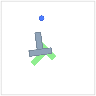

In [21]:
from PIL import Image
env = PushTKeypointsEnv()
env.seed(0)
env.reset()
img = Image.fromarray(env.render(mode='rgb_array'))
display(img)

In [49]:

import gym
from gym import spaces
from PIL import Image
import collections
import numpy as np
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import os
import skimage.transform as st
from diffusion_policy.env.pusht.pymunk_override import DrawOptions
import matplotlib.cm as cm

def get_image_from_obs(points, action, seed, step, timestep, action_mode="Input"):
    center_x, center_y = 96 / 2, 96 / 2
    d_i = 30
    angle = (5 * np.pi) / 4
    end_x = center_x + d_i * np.cos(angle)
    end_y = center_y - d_i * np.sin(angle)
    points_to_average = [
    points[8], points[1] 
    ]
    points_array = np.array(points_to_average)
    average_point = np.mean(points_array, axis=0)

    env = PushTKeypointsEnv()
    canvas = pygame.Surface((env.window_size, env.window_size))
    canvas.fill((255, 255, 255))
    env.screen = canvas
    draw_options = DrawOptions(canvas)
    # Draw goal pose.
    env.space = pymunk.Space()
    goal_body = env._get_goal_pose_body(np.array([256,256,np.pi/4]))
    env.goal_color = pygame.Color('LightGreen')
    block_temp = env.add_tee((256, 300), 0)
    for shape in block_temp.shapes:
        goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
        goal_points += [goal_points[0]]
        pygame.draw.polygon(canvas, env.goal_color, goal_points)
    img = np.transpose(
                    np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
                )
    img = cv2.resize(img, (env.render_size, env.render_size))
    img = Image.fromarray(img)
    plt.imshow(img)
    plt.axis('off')

    # Overlay the points and annotate them
    for idx, (x, y) in enumerate(points):
        if idx == 9:
            plt.scatter(x, y, c='blue', label='Agent start')
        else:
            plt.scatter(x, y, c='red', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
            plt.text(x, y, f'{idx}', fontsize=9, color='blue')

    # Plot arrows for the action trajectory with gradient colors
    num_actions = len(action) - 1
    colors = cm.viridis(np.linspace(0, 1, num_actions)) 
    for i in range(num_actions):
        start_x, start_y = action[i]
        end_x, end_y = action[i + 1]
        dx = end_x - start_x
        dy = end_y - start_y
        if i == 0:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i], label=action_mode+" start")
        elif i == num_actions - 1:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i], label=action_mode+" end")
        else:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i])

    top_left = points[1]     # Left side of the base
    top_right = points[2]    # Right side of the base
    center_top = points[4]   # Top of the T (center vertical bar)
    mid_point = average_point    # Middle connecting point
    # Draw the base of the T (horizontal line)
    plt.plot([top_left[0], top_right[0]], [top_left[1], top_right[1]], c='grey', linewidth=2)
    # Draw the vertical bar of the T
    plt.plot([mid_point[0], center_top[0]], [mid_point[1], center_top[1]], c='grey', linewidth=2)
    # Plot the center of the image
    plt.scatter(center_x, center_y, c='green', label='Center')  # 
    plt.legend(loc='upper left')
    # plt.title("Points and Line Overlay on Image")
    plt.savefig(f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_action{action_mode}.png")
    plt.close()

# Define a function to compute statistics
def compute_stats(row, policy, save_img=True):
    seed, step, timestep, activation = row.values
    seed, step, timestep = int(seed), int(step), int(timestep)
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt", weights_only=True)
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2) / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2) / 512 * 96
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)

    img_saved = os.path.exists(f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionInput.png")
    if save_img and not img_saved:
        get_image_from_obs(points2, inp_action, seed, step, timestep, "Input")
        get_image_from_obs(points2, out_action, seed, step, timestep, "Output")

    # Collect the results in a dictionary
    return {
        "seed": int(seed),
        "step_idx": int(step),
        "timestep": time_ind,
        "activation": activation,
        "theta_tc_deg": theta_tc_deg,
        "theta_c_deg": theta_c_deg,
        "d_tc": d_tc,
        "ClosestK": ClosestK,
        "Delta_theta_act_in": Delta_theta_act_in,
        "Delta_theta_act_out": Delta_theta_act_out,
        "Delta_dist_act_in": Delta_dist_act_in,
        "Delta_dist_act_out": Delta_dist_act_out,
        "d_act_curr_in": d_act_curr_in,
        "d_act_curr_out": d_act_curr_out,
        "d_act_target_in": d_act_target_in,
        "d_act_target_out": d_act_target_out,
        "img_path_in": f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionInput.png",
        "img_path_out": f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionOutput.png"
    }

def round_to_significant_digits(val):
    if isinstance(val, (int, float)):  # Check if the value is numeric
        return float(f"{val:.3g}")  # Format to 3 significant digits
    return val  


In [ ]:

# Process each selected feature index
for feature_idx in range(1024, 2048):
    print(f"Processing feature index: {feature_idx}")
    results = []
    try:
        top_activations = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False).head(20)
    except Exception as e:
        print("Skipping feature ", feature_idx)
        continue
    latent_df = top_activations[['seed', 'step_idx', 'timestep', f'feature_{feature_idx}']]
    non_na_count = better_acts[f"feature_{feature_idx}"].notna().sum()
    if non_na_count < 50:
        print(f"Skipping feature {feature_idx} due to insufficient activations")
        continue
    for idx, row in latent_df.iterrows():
        stats = compute_stats(row, policy)
        results.append(stats)
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results).sort_values("activation", ascending=False)
    # Reduce precision of numerical values to 3 significant digits
    results_df = results_df.apply(
        lambda col: col.map(round_to_significant_digits) if col.dtype in [np.float64, np.int64] else col
    )
    # Save the DataFrame to a CSV file
    results_df.to_csv(f"sae_analysis/out/new/f{feature_idx}_stats.csv", index=False)
    print(f"Saved CSV for feature index: {feature_idx}")

In [ ]:
count_features_with_non_na = 0

for feature_idx in range(2048):
    # print(f"Processing feature index: {feature_idx}")
    try:
        # Check the number of non-NA values in the feature column
        non_na_count = better_acts[f"feature_{feature_idx}"].notna().sum()
        
        if non_na_count > 10:
            print(f"Feature index: {feature_idx}, Non-NA count: {non_na_count}")
            count_features_with_non_na += 1
        
    except Exception as e:
        # print("Skipping feature ", feature_idx)
        continue

print(f"Number of features with more than 50 non-NA values: {count_features_with_non_na}")


In [43]:
30*748

22440

In [44]:
0.5*748/60

6.233333333333333

In [ ]:
# check if a file name exists in a folder
import os
os.path.exists("sae_analysis/out/env_imgs/seed0_step0_timestep0_actionInput.png")


In [21]:
f922_30 = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
)[['seed','step_idx','timestep', f'feature_{feature_idx}']].head(5)
for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    seed, step, timestep = int(seed), int(step), int(timestep)
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
    print(f"Seed: {seed}, Step: {step}, Timestep: {timestep}")
    # print(theta_tc(points1))
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    # print(dist_tc(points1))
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    # print(Ka(points2))
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)
    print(f"Theta_tc: {theta_tc_deg}, d_tc: {d_tc}, ClosestK: {ClosestK} \n Delta_theta_act_in: {Delta_theta_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n Delta_dist_act_in: {Delta_dist_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n d_act_curr_in: {d_act_curr_in} d_act_curr_out: {d_act_curr_out} \n d_act_target_in: {d_act_target_in} d_act_target_out: {d_act_target_out}")
    get_image_from_obs(points2, inp_action, seed, step, timestep, action_mode="Input")
    get_image_from_obs(points2, out_action, seed, step, timestep, action_mode="Output")
    print("\n")

/tmp/ipykernel_1933799/1231549832.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


Seed: 27242, Step: 112, Timestep: 3
Theta_tc: 4.292908334280913, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: 228.07397729338925 Delta_dist_act_out: 8.524491558907302 
 Delta_dist_act_in: 4.612924313909092 Delta_dist_act_out: 8.524491558907302 
 d_act_curr_in: 12.104566669028511 d_act_curr_out: 12.180254695448014 
 d_act_target_in: 15.469839999955132 d_act_target_out: 15.67071618704117


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')




Seed: 30449, Step: 160, Timestep: 1
Theta_tc: -2.9033618997715966, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: 2.857662356274125 Delta_dist_act_out: 7.796555249261298 
 Delta_dist_act_in: 8.82078920555269 Delta_dist_act_out: 7.796555249261298 
 d_act_curr_in: 13.831234245375066 d_act_curr_out: 13.755010382304548 
 d_act_target_in: 16.247847524461836 d_act_target_out: 15.868393522531587


Seed: 30449, Step: 160, Timestep: 0
Theta_tc: -2.9033618997715966, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: -73.89350802642849 Delta_dist_act_out: 6.8138331835571355 
 Delta_dist_act_in: 7.796555249261298 Delta_dist_act_out: 6.8138331835571355 
 d_act_curr_in: 13.755010382304548 d_act_curr_out: 13.503240927422599 
 d_act_target_in: 15.868393522531587 d_act_target_out: 15.520998375859582


Seed: 27242, Step: 112, Timestep: 6
Theta_tc: 4.292908334280913, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: -37.0210391506273 Delta_dist_act_out: 8.009703604550946 
 

/tmp/ipykernel_1886101/799738041.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


0.8350756


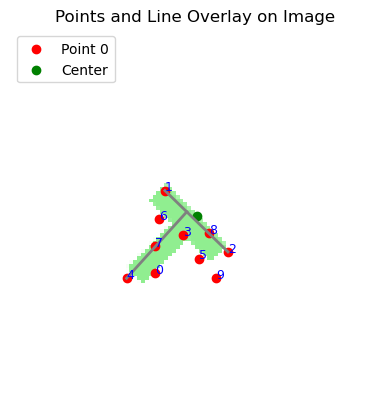

In [96]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example inputs

for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    break
obs = policy.normalizer['obs'].unnormalize(obs)[0][0]  # torch.Size([1, 2, 20])

# Extract the points in (x, y) format
# Reshape the last dimension into 10 pairs of (x, y)
points = np.array(obs.detach().cpu()).reshape(-1, 2)

# Rescale points from [0, 512] to [0, 96]
points = points / 512 * 96
target_action_norm = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
# Center of the image
center_x, center_y = 96 / 2, 96 / 2

# Distance and angle
d_i = 30
angle = (5 * np.pi) / 4  # 45 degrees

# Endpoint of the line
end_x = center_x + d_i * np.cos(angle)
end_y = center_y - d_i * np.sin(angle)  # Subtract because y-coordinates increase downwards in images

_, theta_tc_deg, theta_c_rad, theta_c_deg = theta_tc(points)
print(theta_c_rad)

points_to_average = [
    points[8], points[1] #, points[2]
]

# Convert to a NumPy array for easy computation
points_array = np.array(points_to_average)

# Compute the average
average_point = np.mean(points_array, axis=0)

end_x_curr = average_point[0] + d_i * np.cos(theta_c_rad + np.pi)
end_y_curr = average_point[1] - d_i * np.sin(theta_c_rad + np.pi)  # Subtract because y-coordinates increase downwards in images




env = PushTKeypointsEnv()
# env.reset()
canvas = pygame.Surface((env.window_size, env.window_size))
canvas.fill((255, 255, 255))
env.screen = canvas
draw_options = DrawOptions(canvas)

# Draw goal pose.
env.space = pymunk.Space()
goal_body = env._get_goal_pose_body(np.array([256,256,np.pi/4]))
env.goal_color = pygame.Color('LightGreen')
block_temp = env.add_tee((256, 300), 0) #(average_point[0] / 96 * 512, average_point[1] / 96 * 512), theta_c_rad ) #+ np.pi)
for shape in block_temp.shapes:
    goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
    goal_points += [goal_points[0]]
    pygame.draw.polygon(canvas, env.goal_color, goal_points)

# env.space.debug_draw (draw_options)
img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
img = cv2.resize(img, (env.render_size, env.render_size))
img = Image.fromarray(img)
# display(img)

# Plot the image
image = img  # (96, 96, 3)
plt.imshow(image)
plt.axis('off')

# Overlay the points and annotate them
for idx, (x, y) in enumerate(points):
    plt.scatter(x, y, c='red', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
    plt.text(x, y, f'{idx}', fontsize=9, color='blue')

# for idx, (x, y) in enumerate(target_action_norm):
#     plt.scatter(x, y, c='yellow', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
#     plt.text(x, y, f'{idx}', fontsize=9, color='red')

# Plot arrows for the action trajectory
# for i in range(len(target_action_norm) - 1):
#     start_x_act, start_y_act = target_action_norm[i]
#     end_x_act, end_y_act = target_action_norm[i + 1]
#     dx = end_x_act - start_x_act
#     dy = end_y_act - start_y_act
#     plt.quiver(start_x_act, start_y_act, dx, dy, angles='xy', scale_units='xy', scale=1, color='purple')

top_left = points[1]     # Left side of the base
top_right = points[2]    # Right side of the base
center_top = points[4]   # Top of the T (center vertical bar)
mid_point = average_point    # Middle connecting point

# Draw the base of the T (horizontal line)
plt.plot([top_left[0], top_right[0]], [top_left[1], top_right[1]], c='grey', linewidth=2)

# Draw the vertical bar of the T
plt.plot([mid_point[0], center_top[0]], [mid_point[1], center_top[1]], c='grey', linewidth=2)

# Plot the center of the T
# plt.scatter(mid_point[0], mid_point[1], c='purple', label='Center', s=100)


# Plot the center of the image
plt.scatter(center_x, center_y, c='green', label='Center')  # Center of the image
# plt.scatter(256/512*96, 300/512*96, c='grey', label='Center')  # Center of the image

# Plot the average point
# plt.scatter(average_point[0], average_point[1], c='orange', label='Average Point')
# plt.scatter(1, 1, c='yellow', label='Action')  # Center of the image

# Draw the line
# plt.plot([center_x, end_x], [center_y, end_y], c='purple', label=f'Line d_i={d_i}, angle=pi/4')
# plt.plot([average_point[0], end_x_curr], [average_point[1], end_y_curr], c='blue', label=f'Line d_i={d_i}, angle=pi/4')
plt.legend(loc='upper left')
plt.title("Points and Line Overlay on Image")
plt.show()

In [60]:
(5 * np.pi) / 4

3.9269908169872414

In [55]:
average_point[0] / 96 * 512, average_point[1] / 96 * 512

(261.30478922526044, 268.466796875)

In [51]:
points[8], points[1], points[2]
# avg of the above points 


(array([51.139698, 52.359108], dtype=float32),
 array([39.729767, 41.35932 ], dtype=float32),
 array([56.114487, 57.294136], dtype=float32))

In [52]:
points_to_average = [
    points[8], points[1], points[2]
]

# Convert to a NumPy array for easy computation
points_array = np.array(points_to_average)

# Compute the average
average_point = np.mean(points_array, axis=0)

print("Average Point:", average_point)

Average Point: [48.994648 50.337524]
